## **Introduction**

  Notre objectif au travers de ce projet est d'inférer le taux de la banque centrale européenne.
  Pour cela, nous nous baserons sur une sentiment analysis réalisé sur le compte rendu de la banque centrale européenne lors de la publication du nouveaux taux.
  
  Enfin, nous réaliserons différents modèles afin de prédire la variation de taux à partir d'un score issu de l'analyse de sentiment et de données de marché.

## **I. Initialisation du chrome driver pour selenium**

Afin d'extraire les statement de la banque centrale européenne on utilise un chrome driver et le package selenium nous permettant d'extraire les hyperliens du code HTML de la page de l'ECB.

In [2]:
# Installation des bibliothèques
!pip install selenium


In [4]:
# Initialisation du Chrome Driver

from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('start-maximized')
chrome_options.add_argument('disable-infobars')
chrome_options.add_argument('--disable-extensions')

driver = webdriver.Chrome(options=chrome_options)
driver.maximize_window()

## **II. Extraction des comptes rendus des meetings de la BCE**


Suite à l'initialisation du chrome driver notre but est ici d'extraire tous les hyperliens correspondant aux statement de la BCE du code HTML de la page.

La difficulté ici a été de sélectionner tous les liens car la présence d'une fonction lazyload bloquait l'affichage de certains hyperliens dans le code HTML de la page mère.

Il nous a donc fallu programmer un scroller qui scrollait de manière itérative afin de faire apparaître l'ensemble des hyperliens de la page. (et inclure des temps d'attente pour que le code HTML de la page puisse se charger correctement)

In [5]:
# On charge tout le code html de la page mère en utilsant une méthode de scroll down pour charger tout le code HTML

from selenium.webdriver.common.keys import Keys
import time

url = 'https://www.ecb.europa.eu/press/accounts/html/index.fr.html'
driver.get(url)

# Pause pour permettre le chargement initial de la page
time.sleep(3)

# Définitions du nombre d'étapes et le temps d'attente entre chaque étape (scroll down)
nombre_etapes = 10
temps_attente_entre_etapes = 10  # en secondes

# Scroll down
for etape in range(1, nombre_etapes + 1):
    position_scroll = int(driver.execute_script("return document.body.scrollHeight * {} / {}"
                                                .format(etape, nombre_etapes)))
    driver.execute_script("window.scrollTo(0, {});".format(position_scroll))

    # Pause pour que le contenu se charge
    time.sleep(temps_attente_entre_etapes)

# Extraction du code HTML de la page
html_code = driver.page_source


In [6]:
import re
import pandas as pd

# Extraction de tous les liens de la forme 'press/accounts' qui correspondent aux comptes rendus des meetings
motifs = re.compile(r'/press/accounts/(\d{4}[^"]*)')
resultats = motifs.findall(html_code)

# Filtrer les résultats qui se terminent par "en.html" pour n'avoir que les versions en anglais
resultats_filtres = [phrase for phrase in resultats if phrase.endswith("en.html")]

# On ajoute le prefixe necessaire pour pouvoir accéder directements aux liens des comptes rendus
prefixe = "https://www.ecb.europa.eu/press/accounts/"
phrases_avec_prefixe = [prefixe + phrase for phrase in resultats_filtres]

# Sauvegarde dans un dataframe & Affichage
df = pd.DataFrame({'Lien': phrases_avec_prefixe})
print(df.to_string(index=False))

                                                                                Lien
  https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240118~57d24ff18f.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231123~40c9631bc7.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231012~2f3d803d32.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230831~b04764f45f.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230713~f7e54fdb87.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230601~9d35f80dee.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230420~e8043d2d3d.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230302~009d06dd5a.en.html
  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230119~e522ad4e37.en.html
  https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg221124~3527764024.en.html
  https://www.ecb.europa.eu/press/accounts/2022/html/ecb.mg221006

Après avoir obtenu l'ensemble des hyperliens des statement de la BCE nous nous rendons sur chacune des pages afin d'en extraire le contenu que nous sauvegarderons dans un dataframe.

In [5]:
# Extraction du compte rendu de chaque meeting à partir des liens extraits plus hauts.

from selenium.webdriver.common.by import By

# Fonction pour obtenir le titre et le texte d'une page web en utilisant Selenium

def get_title_and_text(url):
    driver.get(url)
    driver.implicitly_wait(1)

    # Extraction du titre
    title = driver.title

    # Extraction du texte
    text = driver.find_element(By.XPATH, '//body').text

    return title, text


# Filtre sur le format du lien
motifs = re.compile(r'/press/accounts/(\d{4}[^"]*)')
resultats = motifs.findall(html_code)

# Check que le lien est bien en version anglaise
resultats_filtres = [lien for lien in resultats if lien.endswith("en.html")]

# Ajout du préfixe
prefixe = "https://www.ecb.europa.eu/press/accounts/"
liens_avec_prefixe = [prefixe + lien for lien in resultats_filtres]

# Agrégation dans un dataframe
df = pd.DataFrame({'lien': liens_avec_prefixe})
df['Title'] = ""
df['Text'] = ""

# Itération pour chaque URL :
for index, row in df.iterrows():
    url = row['lien']
    title, text = get_title_and_text(url)
    df.at[index, 'Title'] = title
    df.at[index, 'Text'] = text

In [6]:
# Check qu'on extrait bien tous les comptes rendus (74)
longueur = len(df)
print("Longueur du DataFrame :", longueur)

Longueur du DataFrame : 74


In [7]:
# Visualisation du dataframe
pd.set_option('display.max_colwidth', None)
df.head()

lien  \
0  https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240118~57d24ff18f.en.html   
1  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231123~40c9631bc7.en.html   
2  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231012~2f3d803d32.en.html   
3  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230831~b04764f45f.en.html   
4  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230713~f7e54fdb87.en.html   

                             Title  \
0   Meeting of 13-14 December 2023   
1    Meeting of 25-26 October 2023   
2  Meeting of 13-14 September 2023   
3       Meeting of 26-27 July 2023   
4       Meeting of 14-15 June 2023   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## **III.** **Analyse de la tonalité des comptes rendus à l'aide du dictionnaire de Loughran-McDonalds**



Nous crééons une analyse de sentiment en utilisant la méthode du dictionnaire de Loughran-McDonalds vue en cours.

**Remarque sur les données externes** : Pour récupérer le dictionnaire et certaines autres sources de données, on load des datasets stockés dans un drive dont vous avez l'accès. Il sera néanmoins peut être nécessaire pour vous de dupliquer les documents dans votre espace personnel pour pouvoir faire tourner le code correctement.

In [9]:
# Chargement du dictionnaire
file_name = "dictionnaire.csv"
dictio = pd.read_csv(file_name,encoding='latin-1')

In [10]:
# Visualisation du dictionnaire
dictio.head()

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf


Nous réutilisons l'implémentation vue encours afin d'obtenir le sentiment score:

In [11]:
# Création du 'sentiment score' pour chaque compte rendu pour capturer la tonalité de ce dernier

from sklearn.feature_extraction.text import CountVectorizer

funcs = {
    "negative": lambda x: x.Negative > 0,
    "positive": lambda x: x.Positive > 0,
    "all": lambda x: x.Word.notna(),
}

# Definition de la colonne de texte
X = df["Text"]

# Calcul du sentiment score

def get_total_count(X, dictio, func):
    m = CountVectorizer(vocabulary=dictio.loc[func].Word.str.lower().values)
    return pd.DataFrame(m.fit_transform(X).toarray(), index=X.index, columns=m.get_feature_names_out()).sum(axis=1)

lm_counts = pd.concat({k: get_total_count(X, dictio, v) for k, v in funcs.items()}, axis=1)

sentiment_score = (lm_counts["positive"] - lm_counts["negative"]) / lm_counts["all"]

# Ajout du 'sentiment score' au dataframe

df["Sentiment_Score"] = sentiment_score


In [12]:
# Extraction de la date de chacun des meetings

df['Dates of the meeting'] = df['Text'].str.extract(r'(\d{1,2}-\d{1,2} [a-zA-Z]+ \d{4})')
df['Date'] = pd.to_datetime(df['Dates of the meeting'].str.replace(r'-(\d{1,2})', '', regex=True), format='%d %B %Y', errors='coerce')
df['Month_Year'] = df['Date'].dt.to_period('M')

In [13]:
# Visualisation du dataframe
df.head()

lien  \
0  https://www.ecb.europa.eu/press/accounts/2024/html/ecb.mg240118~57d24ff18f.en.html   
1  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231123~40c9631bc7.en.html   
2  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg231012~2f3d803d32.en.html   
3  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230831~b04764f45f.en.html   
4  https://www.ecb.europa.eu/press/accounts/2023/html/ecb.mg230713~f7e54fdb87.en.html   

                             Title  \
0   Meeting of 13-14 December 2023   
1    Meeting of 25-26 October 2023   
2  Meeting of 13-14 September 2023   
3       Meeting of 26-27 July 2023   
4       Meeting of 14-15 June 2023   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [14]:
# Initialisation pour la visualisation des données
!pip install matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

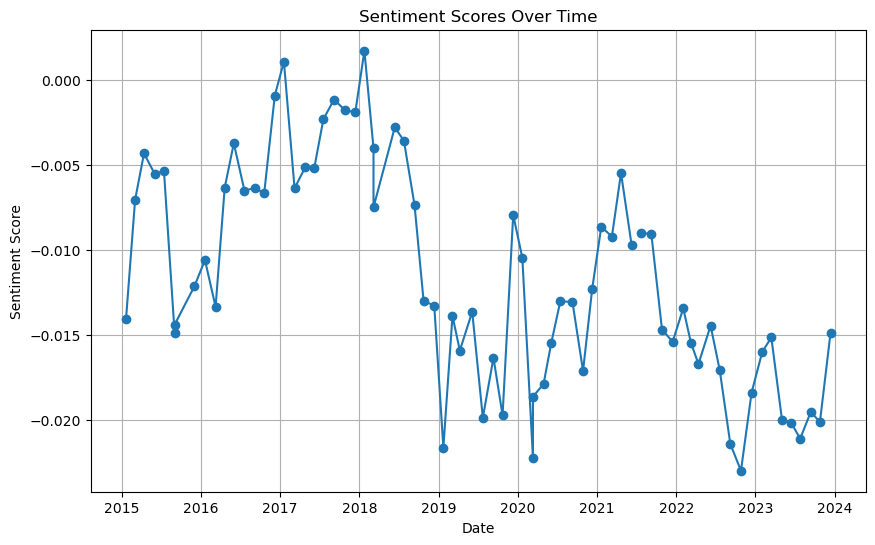

In [15]:
# Graphique du sentiment score
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Sentiment_Score"], marker='o', linestyle='-')
plt.title("Sentiment Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.grid(True)
plt.show()

On parvient à réaliser des sentiment scores sur les compte rendus de la BCE allant de début 2015 à fin 2023.

On remarque que le sentiment score est négatif sur tout la période.

On remarque deux tendances une "moins négative" entre mi-2015 et et mi-2018, et une autre tendance très négative entre 2019 et 2024 avec un rebond dans la période covid. Cependant, ces deux tendances sont extrêment bruitées ce qui pourrait poser des problèmes par la suite.


## **IV. Importation & Visualisation des taux historiques de la BCE**


Nous importons les données de taux directement depuis le site de la BCE. Pour des facilités d'extraction nous avons placé le fichier dans le même dossier que le dictionnaire utilisé précedemment.

Source des données : https://data.ecb.europa.eu/main-figures/ecb-interest-rates-and-exchange-rates/key-ecb-interest-rates

In [16]:
# Chargement de la base
file_name = "ECB_data.csv"
ECB = pd.read_csv(file_name,encoding='latin-1')

In [17]:
ECB.head()

,DATE,TIME PERIOD,Deposit facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.DFR.LEV),Marginal lending facility - date of changes (raw data) - Level (FM.D.U2.EUR.4F.KR.MLFR.LEV),Main refinancing operations - Minimum bid rate/fixed rate (date of changes) - Level (FM.D.U2.EUR.4F.KR.MRR_RT.LEV)
0,1999-01-01,01 Jan 1999,2.00,4.50,3.0
1,1999-01-02,02 Jan 1999,2.00,4.50,3.0
2,1999-01-03,03 Jan 1999,2.00,4.50,3.0
3,1999-01-04,04 Jan 1999,2.75,3.25,3.0
4,1999-01-05,05 Jan 1999,2.75,3.25,3.0


In [18]:
# Nettoyage de la base de données
ECB = ECB[['DATE', ECB.columns[-1]]].rename(columns={ECB.columns[-1]: 'rate'})
ECB['Date'] = pd.to_datetime(ECB['DATE'])
ECB = ECB[['Date', 'rate']]


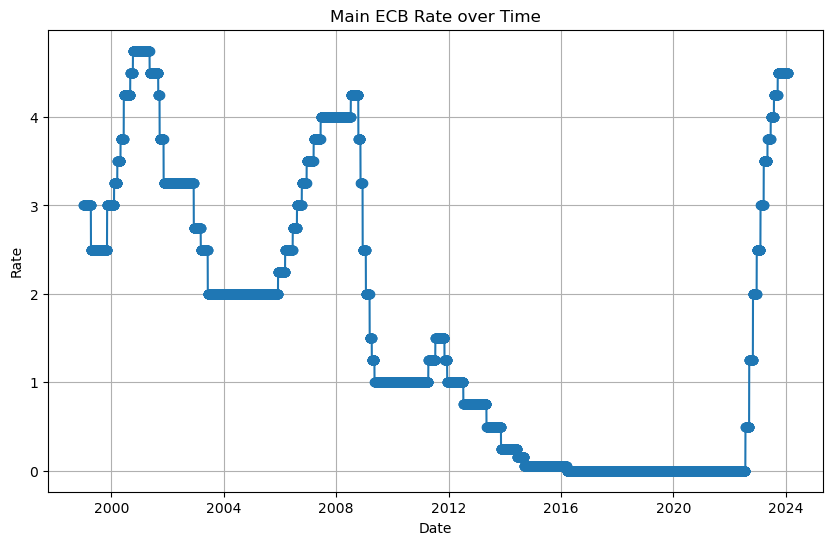

In [19]:
# Visualisation de l'évolution des taux de la BCE dans le temps
plt.figure(figsize=(10, 6))
plt.plot(ECB['Date'], ECB['rate'], marker='o', linestyle='-')
plt.title('Main ECB Rate over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.grid(True)
plt.show()

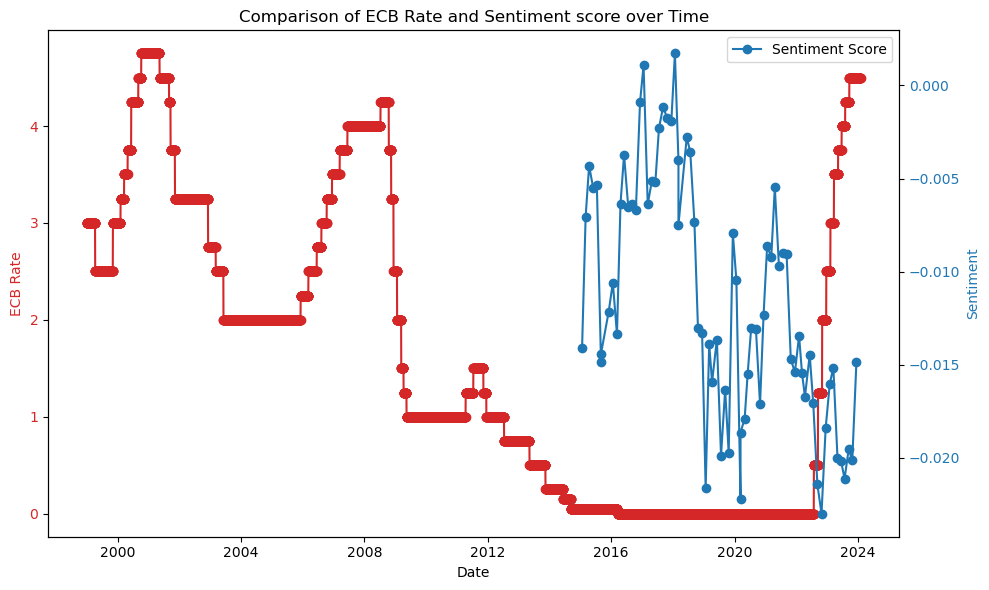

In [20]:
# Visualisation des taux réels et de notre analyse de tonalité

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('ECB Rate', color=color)
ax1.plot(ECB['Date'], ECB['rate'], color=color, label='ECB Rate', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Sentiment', color=color)
ax2.plot(df['Date'],  df["Sentiment_Score"], color=color, label='Sentiment Score', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparison of ECB Rate and Sentiment score over Time')

fig.tight_layout()
plt.legend()

plt.show()

On observe que notre plage de données pour sentiment score est beaucoup plus restreinte que celle des taux de l'ECB.

De plus, on observe tout une plage sur lequel le taux est constant. Ce qui peut être extrêmement difficile à prévoir.

## **V. Introduction d'une autre donnée de marché : le taux de change EUR / USD**


Source des données : https://data.ecb.europa.eu/data/datasets/EXR?dataset%5B0%5D=Exchange%20Rates%20%20%28EXR%29&filterSequence=dataset&advFilterDataset%5B0%5D=Exchange%20Rates%20%20%28EXR%29

On cherche ici à ajouter une base de données qui permet de refléter, entre autres, ce qui est pricé par le marché. Une forte augmentation des taux de la BCE (à taux de la FED constant) devrait pousser l'EUR/USD à la hausse et inversement.

Néanmoins, les résultats de notre analyse sont peu concluants, le taux de change étant déterminé par de trop nombreux facteurs exogènes à notre analyse.

In [22]:
# Chargement de la base
file_name = "ECB_USD_EUR.csv"
ECB_EUR_USD = pd.read_csv(file_name,encoding='latin-1')

In [23]:
# Nettoyage des données
ECB_EUR_USD = ECB_EUR_USD.iloc[:, [0, -1]].rename(columns={ECB_EUR_USD.columns[0]: 'Date', ECB_EUR_USD.columns[-1]: 'EUR/USD'})
ECB_EUR_USD['Date'] = pd.to_datetime(ECB_EUR_USD['Date'])
ECB_EUR_USD = ECB_EUR_USD[['Date', 'EUR/USD']]


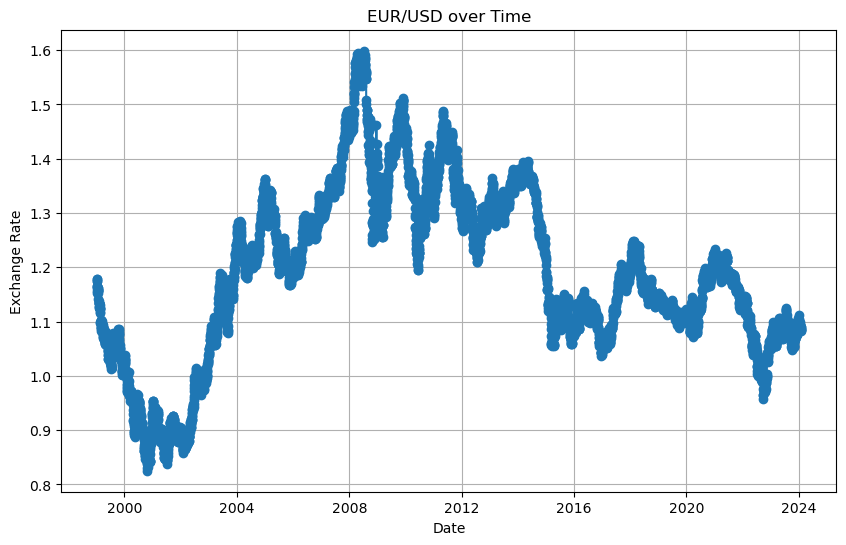

In [24]:
# Visualisation de l'evolution du cours de l'EUR/USD
plt.figure(figsize=(10, 6))
plt.plot(ECB_EUR_USD['Date'], ECB_EUR_USD['EUR/USD'], marker='o', linestyle='-')
plt.title('EUR/USD over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)
plt.show()

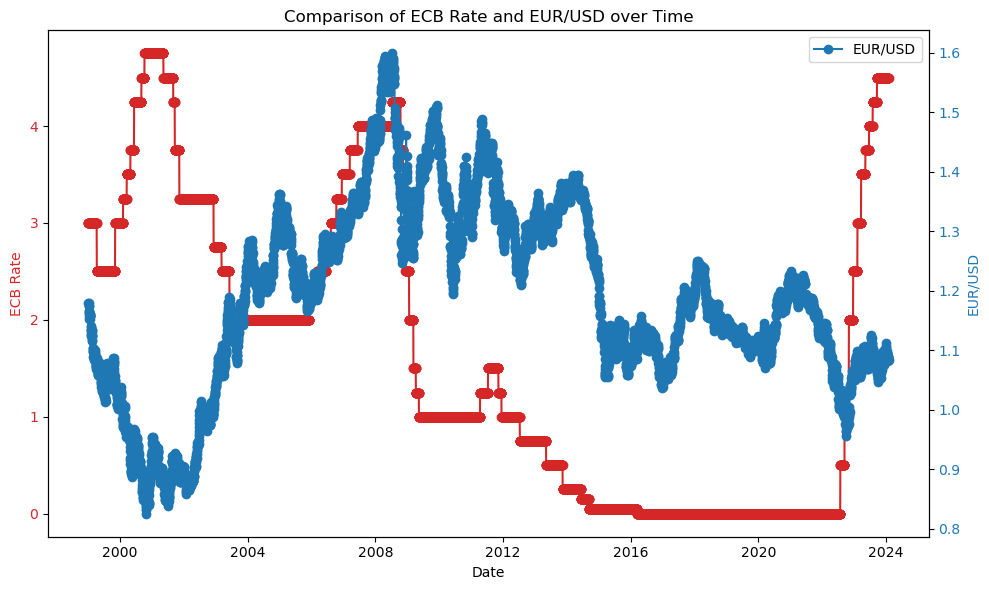

In [25]:
# Visualisation de la relation entre taux et taux de change EUR/USD

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('ECB Rate', color=color)
ax1.plot(ECB['Date'], ECB['rate'], color=color, label='ECB Rate', marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('EUR/USD', color=color)
ax2.plot(ECB_EUR_USD['Date'], ECB_EUR_USD['EUR/USD'], color=color, label='EUR/USD', marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Comparison of ECB Rate and EUR/USD over Time')

fig.tight_layout()
plt.legend()

plt.show()


In [26]:
# Ajout de granularité : visualisation par années

import ipywidgets as widgets
from IPython.display import display, clear_output

ECB['Change'] = ECB['rate'].diff()
ECB_EUR_USD['Change'] = ECB_EUR_USD['EUR/USD'].diff()

def update_plot(selected_year):
    with out:
        clear_output(wait=True)

        plt.figure(figsize=(20, 10))

        ECB_filtered = ECB[ECB['Date'].dt.year == selected_year]
        ECB_EUR_USD_filtered = ECB_EUR_USD[ECB_EUR_USD['Date'].dt.year == selected_year]

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('ECB Rate', color=color)
        ax1.plot(ECB_filtered['Date'], ECB_filtered['rate'], color=color, label='ECB Rate', marker='o')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('EUR/USD', color=color)
        ax2.plot(ECB_EUR_USD_filtered['Date'], ECB_EUR_USD_filtered['EUR/USD'], color=color, label='EUR/USD', marker='o')
        ax2.tick_params(axis='y', labelcolor=color)


        plt.title(f'Comparison of ECB Rate and EUR/USD for {selected_year}')

        fig.tight_layout()
        plt.show()

unique_years = sorted(ECB['Date'].dt.year.unique())

year_dropdown = widgets.Dropdown(
    options=unique_years,
    value=unique_years[0],
    description='Select Year:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

def on_dropdown_change(change):
    update_plot(change.new)

year_dropdown.observe(on_dropdown_change, names='value')

display(year_dropdown)

out = widgets.Output(layout={'border': '1px solid black'})
display(out)

update_plot(unique_years[0])


Dropdown(description='Select Year:', layout=Layout(width='300px'), options=(1999, 2000, 2001, 2002, 2003, 2004…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [27]:
# Ajout de granularité : visualisation par mois

import calendar

ECB['Change'] = ECB['rate'].diff()
ECB_EUR_USD['Change'] = ECB_EUR_USD['EUR/USD'].diff()


unique_years = sorted(ECB['Date'].dt.year.unique())
unique_months = list(calendar.month_name)[1:]

year_dropdown = widgets.Dropdown(
    options=unique_years,
    value=unique_years[0],
    description='Select Year:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

month_dropdown = widgets.Dropdown(
    options=unique_months,
    value=unique_months[0],
    description='Select Month:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

display(year_dropdown)
display(month_dropdown)

def update_plot(selected_year, selected_month):
    with out:
        clear_output(wait=True)

        plt.figure(figsize=(20, 10))

        month_number = list(calendar.month_name).index(selected_month)

        ECB_filtered = ECB[(ECB['Date'].dt.year == selected_year) & (ECB['Date'].dt.month == month_number)]
        ECB_EUR_USD_filtered = ECB_EUR_USD[(ECB_EUR_USD['Date'].dt.year == selected_year) & (ECB_EUR_USD['Date'].dt.month == month_number)]

        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Date')
        ax1.set_ylabel('ECB Rate', color=color)
        ax1.plot(ECB_filtered['Date'], ECB_filtered['rate'], color=color, label='ECB Rate', marker='o')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('EUR/USD', color=color)
        ax2.plot(ECB_EUR_USD_filtered['Date'], ECB_EUR_USD_filtered['EUR/USD'], color=color, label='EUR/USD', marker='o')
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f'Comparison of ECB Rate and EUR/USD for {selected_year}-{selected_month}')

        fig.tight_layout()
        plt.show()

def on_year_dropdown_change(change):
    update_plot(change.new, month_dropdown.value)

def on_month_dropdown_change(change):
    update_plot(year_dropdown.value, change.new)

year_dropdown.observe(on_year_dropdown_change, names='value')
month_dropdown.observe(on_month_dropdown_change, names='value')


out = widgets.Output(layout={'border': '1px solid black'})
display(out)
update_plot(unique_years[0], unique_months[0])


Dropdown(description='Select Year:', layout=Layout(width='300px'), options=(1999, 2000, 2001, 2002, 2003, 2004…

Dropdown(description='Select Month:', layout=Layout(width='300px'), options=('January', 'February', 'March', '…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

## **VI. Prédiction du taux directeur**

On souhaite réaliser une prédiction du taux directeur avec différentes variables explicatives.

On crée tout d'abord un dataframe avec la variable cible et la variable explicative.

In [28]:
#Sentiment Score dataframe
df_sentiment_score = df[["Date","Sentiment_Score"]]
df_sentiment_score.set_index("Date",inplace = True)
print(df_sentiment_score)

#ECB rate dataframe
ECB_rates = ECB[["Date","rate"]]
ECB_rates.set_index("Date",inplace=True)
print(ECB_rates)

#ECB EUR/DOLLAR dataframe
ECB_changes = ECB_EUR_USD[["Date","Change"]]
ECB_changes.set_index("Date",inplace=True)
print(ECB_changes)

#Old ECB rate corresponds to the ECB rate dataframes shifted by -1
Old_ecb_rate = ECB_rates.copy()
Old_ecb_rate['Old_ecb_rate'] = Old_ecb_rate['rate'].shift(-1)
Old_ecb_rate.drop('rate', axis=1, inplace=True)
print(Old_ecb_rate)

#
merged_df = pd.merge(df_sentiment_score, ECB_rates, how='inner', left_index=True, right_index=True)
merged_df = pd.merge(merged_df, ECB_changes, how='inner', left_index=True, right_index=True)
merged_df = pd.merge(merged_df, Old_ecb_rate, how='inner', left_index=True, right_index=True)
print(merged_df)

            Sentiment_Score
Date                       
2023-12-13        -0.014874
2023-10-25        -0.020139
2023-09-13        -0.019532
2023-07-26        -0.021118
2023-06-14        -0.020165
...                     ...
2015-07-15        -0.005357
2015-06-02        -0.005517
2015-04-14        -0.004322
2015-03-04        -0.007045
2015-01-21        -0.014083

[74 rows x 1 columns]
            rate
Date            
1999-01-01   3.0
1999-01-02   3.0
1999-01-03   3.0
1999-01-04   3.0
1999-01-05   3.0
...          ...
2024-01-27   4.5
2024-01-28   4.5
2024-01-29   4.5
2024-01-30   4.5
2024-01-31   4.5

[9162 rows x 1 columns]
            Change
Date              
1999-01-04     NaN
1999-01-05  0.0001
1999-01-06 -0.0047
1999-01-07 -0.0111
1999-01-08  0.0027
...            ...
2024-01-25 -0.0012
2024-01-26 -0.0022
2024-01-29 -0.0048
2024-01-30  0.0023
2024-01-31 -0.0009

[6486 rows x 1 columns]
            Old_ecb_rate
Date                    
1999-01-01           3.0
1999-01-02          

On réalise maintenant une régression linéaire qui nous permettra d'obtenir le taux à partir des varibales explicatives.

In [29]:
import statsmodels.api as sm

# Sélectionner les variables explicatives
X = merged_df.drop(['rate'], axis=1)

# Ajouter une colonne constante pour l'intercept
X = sm.add_constant(X)

# Sélectionner la variable expliquée
y = merged_df['rate']

# Créer le modèle de régression
model = sm.OLS(y, X).fit()

# Afficher les résultats de la régression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.652e+32
Date:                Fri, 09 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:39:52   Log-Likelihood:                 2521.0
No. Observations:                  73   AIC:                            -5034.
Df Residuals:                      69   BIC:                            -5025.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4.857e-16    6.2e-17     

On observe un très bon R² mais qui est du au fait que le taux est totalement prédit par l'ancien taux. Cela se voit notamment à la valeur des coefficients de chaque facteur (celui de l'ancien taux est de l'ordre unitaire tandis que les autres sont d'ordre 10^(-15).

Dorénavant, notre but est donc de prédire la variation du taux de la BCE à partir des différentes variables explicatives.

Pour cela, il nous faut tout d'abord construire un dataframe des variations de taux.

Cela serait très simple si les dates des press release correspondaient exactement aux variations de taux de la BCE. Neanmoins, ce n'est pas le cas.

Une première étape est donc de un dataframe des variations des taux de la bce avec la fonctione .diff() de panda et de sélectionner uniquement les variations non nulles qui sont des variations des taux de la BCE mais qui ne détectent pas cependant le maintien du taux de la BCE (cas que nous traiterons ensuite).

In [36]:
#Sentiment Score dataframe
df_sentiment_score = df[["Date","Sentiment_Score"]]
print(df_sentiment_score)

#ECB rate dataframe
ECB_rates = ECB[["Date","rate"]]
ECB_rates.set_index("Date",inplace=True)

#ECB rate variation
ECB_variation = ECB_rates.loc['2015-01-21':'2023-12-13']
ECB_variation['Variation'] = ECB_variation['rate'].diff()
ECB_variation_nonzero = ECB_variation[ECB_variation['Variation'] != 0]
ECB_variation_nonzero.drop('rate', axis = 1, inplace=True)
print(ECB_variation_nonzero)



         Date  Sentiment_Score
0  2023-12-13        -0.014874
1  2023-10-25        -0.020139
2  2023-09-13        -0.019532
3  2023-07-26        -0.021118
4  2023-06-14        -0.020165
..        ...              ...
69 2015-07-15        -0.005357
70 2015-06-02        -0.005517
71 2015-04-14        -0.004322
72 2015-03-04        -0.007045
73 2015-01-21        -0.014083

[74 rows x 2 columns]
            Variation
Date                 
2015-01-21        NaN
2016-03-16      -0.05
2022-07-27       0.50
2022-09-14       0.75
2022-11-02       0.75
2022-12-21       0.50
2023-02-08       0.50
2023-03-22       0.50
2023-05-10       0.25
2023-06-21       0.25
2023-08-02       0.25
2023-09-20       0.25


C:\Users\hugob\AppData\Local\Temp\ipykernel_1120\3320870968.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ECB_variation['Variation'] = ECB_variation['rate'].diff()
C:\Users\hugob\AppData\Local\Temp\ipykernel_1120\3320870968.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ECB_variation_nonzero.drop('rate', axis = 1, inplace=True)


On obtient un message d'erreur qui n'a pas de conséquence sur la suite.

Le problème ici est que la date du statement de la BCE ne correspond pas à la nouvelle hausse du taux.

La logique est donc la suivante:

*  Pour chaque variation de taux on cherche le statement de la BCE dans les 3
semaines avant et après la variation de taux

*  Si on trouve un statement alors la variation correspond au changement de taux de la BCE

*  Si on ne trouve rien alors le taux a été maintenu ou bien la variation n'est pas comprise dans les 3 semaines (cas que l'on cherche à éviter)

In [31]:
from datetime import timedelta

# Copiez df_sentiment_score dans regression_dataframe
regression_dataframe = df_sentiment_score.copy()
regression_dataframe.set_index("Date",inplace = True)
# Créez une nouvelle colonne 'Variation' dans regression_dataframe
regression_dataframe['Variation'] = 0

for index in ECB_variation_nonzero.index:
    # Récupérez la date correspondante à l'indice
    current_date = index

    # Calculez les dates + et - 3 semaines
    three_weeks_before = (current_date - timedelta(weeks=2)).strftime('%Y-%m-%d')
    three_weeks_after = (current_date + timedelta(weeks=2)).strftime('%Y-%m-%d')

    date_in_range = regression_dataframe.index[(regression_dataframe.index >= three_weeks_before) & (regression_dataframe.index <= three_weeks_after)]
    # Si une date est trouvée, assignez la valeur de la colonne 'Variation' de ECB_variation_nonzero
    if not date_in_range.empty:
      regression_dataframe.loc[date_in_range, 'Variation'] = ECB_variation_nonzero.loc[index, 'Variation']

regression_dataframe = regression_dataframe.dropna()
print(regression_dataframe)

            Sentiment_Score  Variation
Date                                  
2023-12-13        -0.014874       0.00
2023-10-25        -0.020139       0.00
2023-09-13        -0.019532       0.25
2023-07-26        -0.021118       0.25
2023-06-14        -0.020165       0.25
...                     ...        ...
2015-09-02        -0.014875       0.00
2015-07-15        -0.005357       0.00
2015-06-02        -0.005517       0.00
2015-04-14        -0.004322       0.00
2015-03-04        -0.007045       0.00

[73 rows x 2 columns]


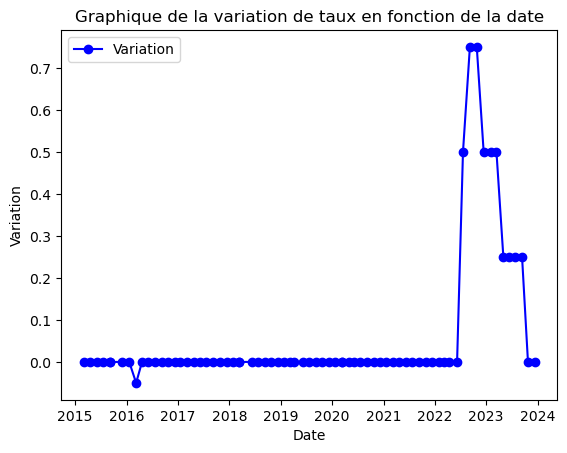

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Tracez la colonne en fonction de l'indice
plt.plot(regression_dataframe.index, regression_dataframe['Variation'], marker='o', linestyle='-', color='b', label='Variation')
plt.xlabel('Date')
plt.ylabel('Variation')
plt.title('Graphique de la variation de taux en fonction de la date')
plt.legend()
plt.show()

On obtient un graphique qui correspond à la variation du taux observée précédemment.

On utilise différentes méthodes pour tenter de prédire la variation de taux avec **tout d'abord le kNN.**

In [33]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

# Supposons que vous ayez déjà défini regression_dataframe avec 'Variation' et 'Sentiment_Score'

# Divisez les données en variables explicatives (X) et variable expliquée (y)
X = regression_dataframe[['Sentiment_Score']]
y = regression_dataframe['Variation']

# Divisez les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définissez les paramètres que vous souhaitez tester
param_grid = {'n_neighbors': np.arange(1, 21)}  # Essayez des valeurs de k de 1 à 20

# Créez le modèle KNN
knn_model = KNeighborsRegressor()

# Utilisez GridSearchCV pour trouver le meilleur paramètre k avec validation croisée
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='r2', refit=True)
grid_search.fit(X_train, y_train)

# Affichez le meilleur paramètre k trouvé
best_k = grid_search.best_params_['n_neighbors']
print(f"Meilleur paramètre k trouvé : {best_k}")

# Utilisez le meilleur modèle pour prédire sur l'ensemble de test
y_pred = grid_search.predict(X_test)

# Obtenez le score (coefficient de détermination R²) sur l'ensemble de test
r2_score_test = grid_search.score(X_test, y_test)
print(f'R² sur l\'ensemble de test avec le meilleur k : {r2_score_test}')


Meilleur paramètre k trouvé : 13
R² sur l'ensemble de test avec le meilleur k : 0.11147828703239415


On obtient un résultat assez médiocre.

On teste par la suite **une régression polynomiale en ajoutant le proxy de marché.**


Régression polynomiale (degré=2):
R² (coefficient de détermination) : 0.36248422041030215


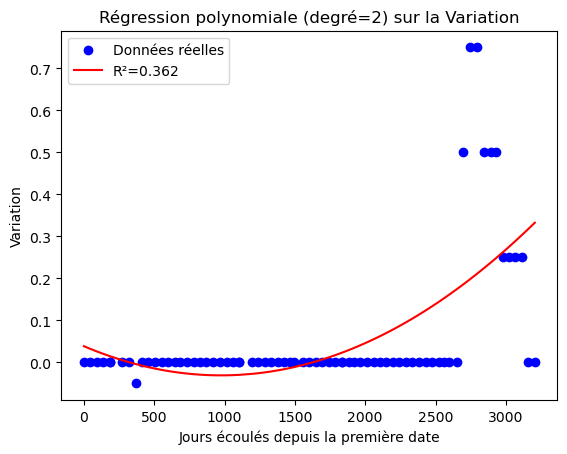


Régression polynomiale (degré=4):
R² (coefficient de détermination) : 0.4258999838967603


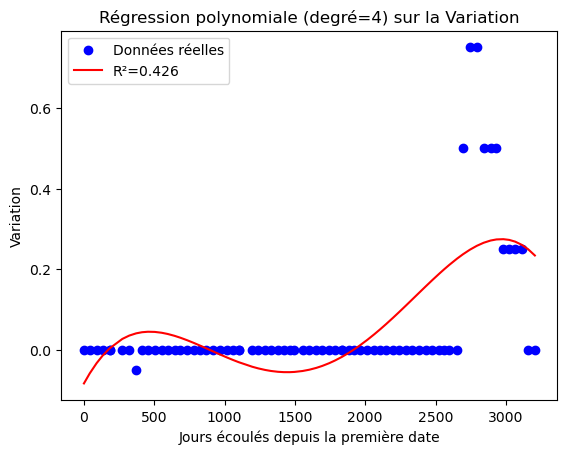


Régression polynomiale (degré=6):
R² (coefficient de détermination) : 0.6303273566668579


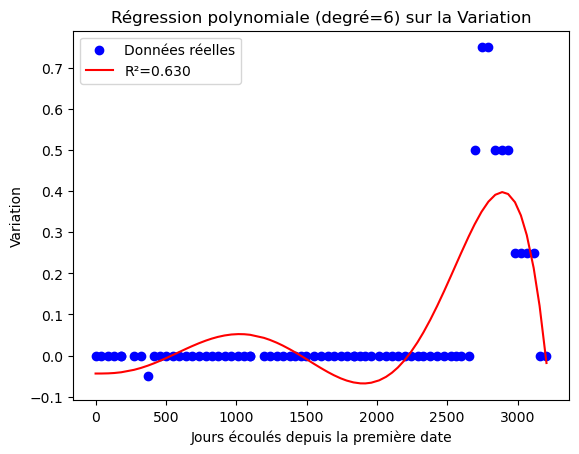


Régression polynomiale (degré=8):
R² (coefficient de détermination) : 0.6965855637253584


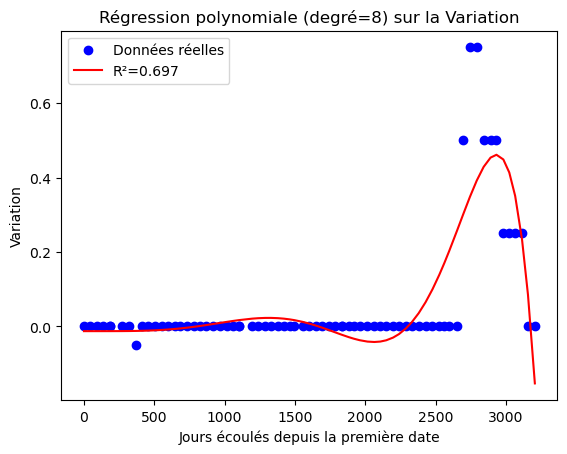


Régression polynomiale (degré=10):
R² (coefficient de détermination) : 0.6854605903419975


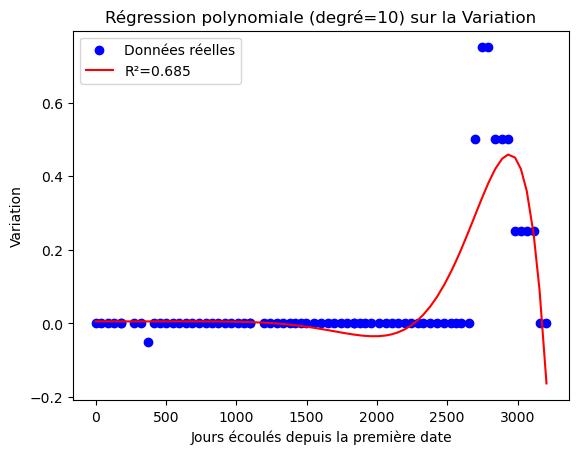


Régression polynomiale (degré=12):
R² (coefficient de détermination) : 0.6970310080980013


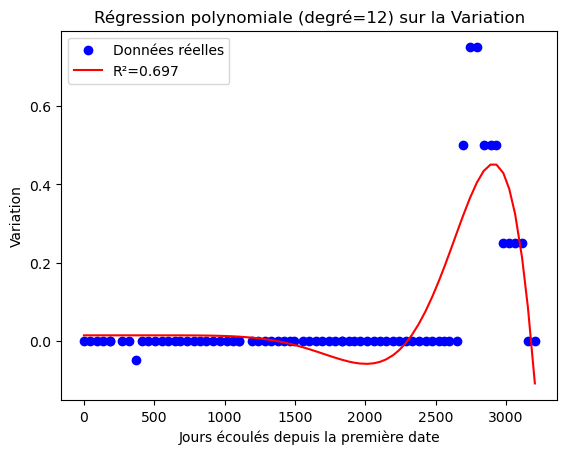


Régression polynomiale (degré=14):
R² (coefficient de détermination) : 0.7356571287755937


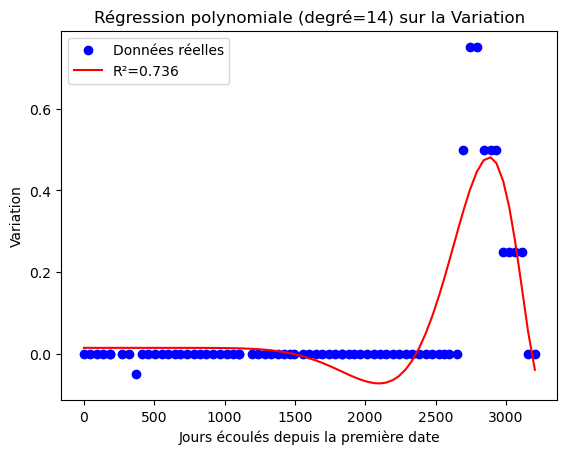

In [34]:
regression_dataframe = pd.merge(regression_dataframe,ECB_changes , how='inner', left_index=True, right_index=True)

import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Extraction des données
X = (regression_dataframe.index - regression_dataframe.index[0]).days.values.reshape(-1, 1)
y = regression_dataframe['Variation'].to_numpy()

# Affichage des résultats pour différents degrés
for degree in range(2, 16, 2):
    # Création des termes polynomiaux
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Entraînement du modèle de régression linéaire
    model = LinearRegression()
    model.fit(X_poly, y)

    # Prédiction des valeurs de Variation
    y_pred = model.predict(X_poly)

    # Calcul du R²
    r2 = r2_score(y, y_pred)

    # Affichage des résultats
    print(f"\nRégression polynomiale (degré={degree}):")
    print(f"R² (coefficient de détermination) : {r2}")

    # Affichage du graphique
    plt.scatter(X, y, color='blue', label='Données réelles')
    plt.plot(X, y_pred, color='red', label=f'R²={r2:.3f}')
    plt.title(f'Régression polynomiale (degré={degree}) sur la Variation')
    plt.xlabel('Jours écoulés depuis la première date')
    plt.ylabel('Variation')
    plt.legend()
    plt.show()


On observe que même lorsque le degré est très élevé (14) le R² n'atteint que 0.73.

## **VII. Conclusion**

Nous sommes parvenus à extraire les données de la BCE malgré la présence du lazy qui contraignait la récupération des hyperliens.

Après avoir récupéré ces hyperliens nous sommes parvenus à en extraire le contenu et à réaliser notre sentiment analysis. Nous avons alors pu constater qu'elle était extrêmement bruitée et ne réflétait pas la réalité des changements de taux.

Il s'en suit alors que nos différents modèles de prédiction utilisant notre sentiment analysis mais aussi d'autre variables ne sont pas concluants. Bien que la régression polynomiale puisse paraître décente pour un degré elevé elle présentera probabelement un cas d'overfitting et ne sera donc pas capable de prédire des valeurs futurs des taux.

Notre projet n'a donc que partiellement abouti.